## Pendahuluan

Dokumen ini menyajikan analisis regresi linier berganda menggunakan metode *Ordinary Least Squares* (OLS). Tujuannya adalah untuk memodelkan hubungan antara variabel dependen `y` dengan variabel independen `x1`, `x2`, dan `x3`.

Analisis ini akan mencakup seluruh alur kerja standar, mulai dari pemuatan data, pembangunan model, validasi asumsi, hingga evaluasi akhir model.

## 1. Memuat Paket dan Data

### Memuat Paket Python yang Diperlukan
Kita akan menggunakan `pandas` untuk manipulasi data, `statsmodels` untuk pemodelan statistik, `matplotlib` dan `seaborn` untuk visualisasi, serta `scipy` untuk beberapa uji statistik.

In [5]:
# Impor paket untuk manipulasi data
import pandas as pd

# Impor paket untuk pemodelan statistik
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Impor paket untuk uji statistik
from scipy import stats

# Impor paket untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur agar plot ditampilkan di dalam notebook
%matplotlib inline
sns.set_style('whitegrid')

### Mengimpor Data dari File Excel

In [6]:
# Ganti path file di bawah ini sesuai lokasi di komputer Anda!
file_path = "C:/Users/user/OneDrive - untirta.ac.id/R Script/Github_Regresi_OLS/data_simulasi_gls.xlsx"
data_OLS = pd.read_excel(file_path)

### Menampilkan Data yang Diimpor

In [7]:
# Menampilkan 6 baris pertama data
data_OLS.head(6)

,y,x1,x2,x3,time
0,44.245264,1,63.957209,53.708923,1
1,35.033373,2,48.545686,37.719907,2
2,47.918691,3,50.852951,48.378023,3
3,59.391126,4,49.905935,60.880715,4
4,45.621889,5,66.817071,53.592014,5
5,76.923170,6,50.255130,60.671912,6


## 2. Pemodelan OLS dan Ringkasan Model
Kita akan menggunakan `statsmodels.formula.api` untuk membangun model. Pustaka ini memungkinkan kita untuk menulis formula regresi dengan sintaks R-style (`"y ~ x1 + x2 + x3"`), yang sangat intuitif untuk pemodelan statistik.

In [8]:
# Membangun model OLS
model_ols = smf.ols('y ~ x1 + x2 + x3', data=data_OLS).fit()

# Menampilkan ringkasan model yang komprehensif
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     7.929
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           8.86e-05
Time:                        14:21:54   Log-Likelihood:                -609.73
No. Observations:                 100   AIC:                             1227.
Df Residuals:                      96   BIC:                             1238.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8581     70.506      0.012      0.9

## 3. Uji Asumsi Klasik (Diagnostik Sisaan)

### Analisis Grafis Sisaan
Analisis visual dari sisaan adalah langkah penting untuk mengevaluasi kualitas model. Kita akan membuat beberapa plot diagnostik standar untuk memeriksa linearitas, normalitas, dan homoskedastisitas.

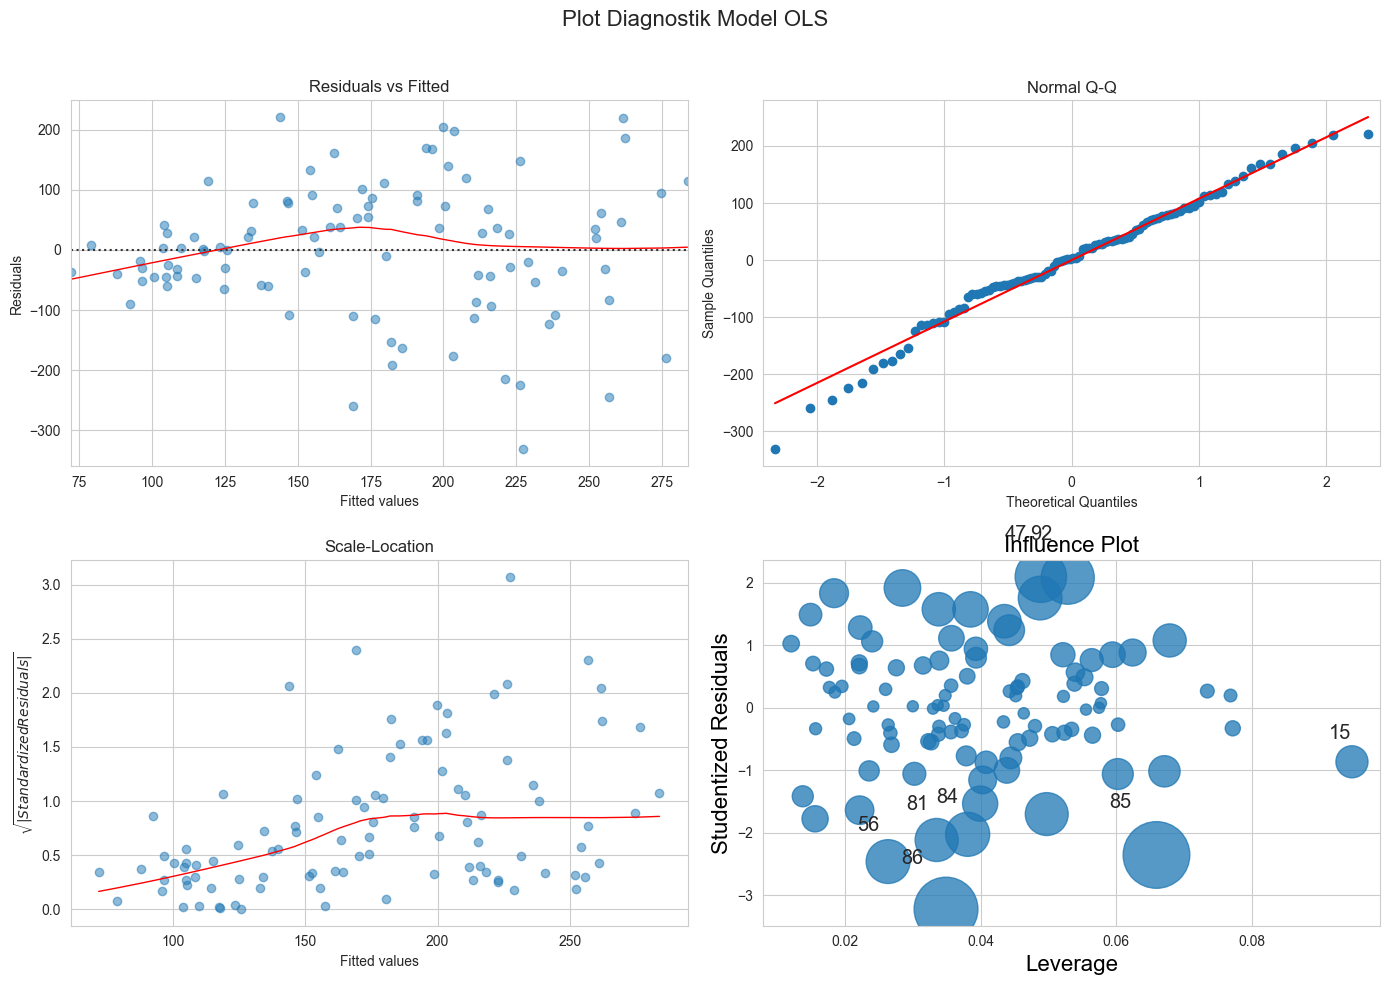

In [9]:
# Dapatkan hasil prediksi dan sisaan
fitted_vals = model_ols.fittedvalues
residuals = model_ols.resid
student_residuals = model_ols.get_influence().resid_studentized_internal
sqrt_student_residuals = pd.Series(student_residuals).pow(2).pow(0.5)

# Membuat 4 plot diagnostik
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Plot Diagnostik Model OLS', fontsize=16)

# 1. Residuals vs Fitted
sns.residplot(x=fitted_vals, y=residuals, lowess=True, ax=axes[0, 0], 
              line_kws={'color': 'red', 'lw': 1}, scatter_kws={'alpha': 0.5})
axes[0, 0].set_title('Residuals vs Fitted')
axes[0, 0].set_xlabel('Fitted values')
axes[0, 0].set_ylabel('Residuals')

# 2. Normal Q-Q
sm.qqplot(residuals, line='s', ax=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q')

# 3. Scale-Location
sns.regplot(x=fitted_vals, y=sqrt_student_residuals, lowess=True, ax=axes[1, 0], 
            line_kws={'color': 'red', 'lw': 1}, scatter_kws={'alpha': 0.5})
axes[1, 0].set_title('Scale-Location')
axes[1, 0].set_xlabel('Fitted values')
axes[1, 0].set_ylabel('$\\sqrt{|Standardized Residuals|}$')

# 4. Residuals vs Leverage (plot ini disederhanakan)
sm.graphics.influence_plot(model_ols, ax=axes[1, 1], criterion='cooks')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Uji Formal Asumsi

#### Uji Normalitas (Shapiro-Wilk)
**Tujuan:** Menguji apakah sisaan model berdistribusi normal.

**Hipotesis:**
- $H_0$: Sisaan berdistribusi normal.
- $H_1$: Sisaan tidak berdistribusi normal.

**Kriteria Keputusan:** Tolak $H_0$ jika *p-value* < 0.05. Asumsi normalitas terpenuhi jika *p-value* > 0.05.

In [10]:
shapiro_test = stats.shapiro(residuals)
print(f"Uji Normalitas (Shapiro-Wilk)")
print(f"Statistik Uji: {shapiro_test.statistic:.4f}")
print(f"P-value: {shapiro_test.pvalue:.4f}")

Uji Normalitas (Shapiro-Wilk)
Statistik Uji: 0.9831
P-value: 0.2304


#### Uji Homoskedastisitas (Breusch-Pagan)
**Tujuan:** Menguji apakah varians dari sisaan konstan.

**Hipotesis:**
- $H_0$: Varians sisaan konstan (homoskedastisitas).
- $H_1$: Varians sisaan tidak konstan (heteroskedastisitas).

**Kriteria Keputusan:** Tolak $H_0$ jika *p-value* < 0.05.

In [11]:
bp_test = het_breuschpagan(residuals, model_ols.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print("Uji Homoskedastisitas (Breusch-Pagan)")
for label, value in zip(labels, bp_test):
    print(f"{label}: {value:.4f}")

Uji Homoskedastisitas (Breusch-Pagan)
LM Statistic: 20.1846
LM-Test p-value: 0.0002
F-Statistic: 8.0925
F-Test p-value: 0.0001


#### Uji Autokorelasi (Durbin-Watson)
**Tujuan:** Menguji apakah ada korelasi antar sisaan, yang umumnya menjadi masalah pada data deret waktu.

**Kriteria Keputusan:** Nilai statistik yang mendekati 2 mengindikasikan tidak adanya autokorelasi. Nilai < 1.5 menunjukkan autokorelasi positif, dan nilai > 2.5 menunjukkan autokorelasi negatif. `statsmodels` juga menampilkan statistik ini secara otomatis di ringkasan model utama.

In [12]:
dw_stat = durbin_watson(residuals)
print(f"Uji Autokorelasi (Durbin-Watson)")
print(f"Statistik D-W: {dw_stat:.4f}")

Uji Autokorelasi (Durbin-Watson)
Statistik D-W: 0.7408


#### Uji Multikolinearitas (VIF)
**Tujuan:** Mendeteksi adanya korelasi yang tinggi antar variabel independen.

**Kriteria Keputusan:** Nilai *Variance Inflation Factor* (VIF) > 5 atau 10 mengindikasikan adanya masalah multikolinearitas.

In [13]:
# Ambil variabel independen dari data
X = data_OLS[['x1', 'x2', 'x3']]
# Tambahkan konstanta (intercept) ke X, ini penting untuk VIF
X = sm.add_constant(X, has_constant='add')

# Buat DataFrame untuk menyimpan hasil VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Hitung VIF untuk setiap fitur
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("Uji Multikolinearitas (VIF)")
# Tampilkan VIF hanya untuk variabel independen (bukan konstanta)
print(vif_data[vif_data['feature'] != 'const'])

Uji Multikolinearitas (VIF)
  feature       VIF
1      x1  1.007994
2      x2  1.002954
3      x3  1.010958


## 4. Evaluasi Kebaikan Model (Goodness-of-Fit)

In [14]:
# Ekstrak metrik dari model
r_squared = model_ols.rsquared
adj_r_squared = model_ols.rsquared_adj
model_aic = model_ols.aic
model_bic = model_ols.bic

# Buat DataFrame untuk menampilkan hasil
evaluasi_data = {
    'Metrik': ['R-squared', 'Adjusted R-squared', 'AIC', 'BIC'],
    'Nilai': [r_squared, adj_r_squared, model_aic, model_bic]
}
evaluasi_df = pd.DataFrame(evaluasi_data)

print("Metrik Kebaikan Model (Goodness-of-Fit)")
evaluasi_df

Metrik Kebaikan Model (Goodness-of-Fit)


,Metrik,Nilai
0,R-squared,0.198586
1,Adjusted R-squared,0.173542
2,AIC,1227.457396
3,BIC,1237.878077
